In [1]:
import os
from pathlib import Path

try:
  import google.colab
  IN_COLAB = True
  print("Running on a Colab Notebook environment")
except:
  IN_COLAB = False

print("os.environ.get('KAGGLE_URL_BASE') == ", os.environ.get('KAGGLE_URL_BASE'))
if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    print("Running on a Kaggle notebook environment")
    IN_KAGGLE = True
else:
    IN_KAGGLE = False

print(IN_COLAB)
print(IN_KAGGLE)
if IN_COLAB:
    if(os.path.isdir('input/jpx-tokyo-stock-exchange-prediction')==False):
        from google.colab import files
        files.upload()
        ! mkdir ~/.kaggle 
        ! cp kaggle.json ~/.kaggle/ 
        ! chmod 600 ~/.kaggle/kaggle.json 
        ! kaggle competitions download -c jpx-tokyo-stock-exchange-prediction
        ! mkdir input
        ! mkdir input/jpx-tokyo-stock-exchange-prediction
        ! unzip jpx-tokyo-stock-exchange-prediction.zip -d input/jpx-tokyo-stock-exchange-prediction

Running on a Colab Notebook environment
os.environ.get('KAGGLE_URL_BASE') ==  None
True
False


Saving kaggle.json to kaggle.json
 96% 231M/241M [00:02<00:00, 131MB/s]
100% 241M/241M [00:02<00:00, 120MB/s]
Archive:  jpx-tokyo-stock-exchange-prediction.zip
  inflating: input/jpx-tokyo-stock-exchange-prediction/data_specifications/options_spec.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_list_spec.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_price_spec.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv  
  inflating: input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_s

In [2]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
from tqdm.auto import tqdm
import copy
import random
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))
colors=px.colors.qualitative.Plotly
root=Path('../input')
if IN_COLAB:
    root =Path('input')
train_path=root/'jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv'


stock_list_path=root/"jpx-tokyo-stock-exchange-prediction/stock_list.csv"

train=pd.read_csv(train_path, parse_dates=['Date'])
stock_list=pd.read_csv(stock_list_path)

print("The training data begins on {} and ends on {}.\n".format(train.Date.min(),train.Date.max()))
display(train.describe().style.format('{:,.2f}'))

The training data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,"2,332,531.00","2,324,923.00","2,324,923.00","2,324,923.00","2,324,923.00","2,332,531.00","2,332,531.00","18,865.00","2,332,293.00"
mean,"5,894.84","2,594.51","2,626.54","2,561.23","2,594.02","691,936.56",1.00,22.02,0.00
std,"2,404.16","3,577.19","3,619.36","3,533.49","3,576.54","3,911,255.94",0.07,29.88,0.02
min,"1,301.00",14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,"3,891.00","1,022.00","1,035.00","1,009.00","1,022.00","30,300.00",1.00,5.00,-0.01
50%,"6,238.00","1,812.00","1,834.00","1,790.00","1,811.00","107,100.00",1.00,15.00,0.00
75%,"7,965.00","3,030.00","3,070.00","2,995.00","3,030.00","402,100.00",1.00,30.00,0.01
max,"9,997.00","109,950.00","110,500.00","107,200.00","109,550.00","643,654,000.00",20.00,"1,070.00",1.12


In [3]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        #print(purchase - short)
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [4]:


def get_label(price, code):
    """ Labelizer
    Args:
        price (pd.DataFrame): dataframe of stock_price.csv
        code (int): Local Code in the universe
    Returns:
        df (pd.DataFrame): label data
    """
    df = price.loc[price["SecuritiesCode"] == code].copy()
    df.loc[:, "label"] = df["Target"]

    return df.loc[:, ["SecuritiesCode", "label"]]



In [5]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [6]:
stock_list

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,9994,20211230,YAMAYA CORPORATION,First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,2447.0,1.084787e+07,2.654474e+10,True
4413,9995,20211230,"GLOSEL Co.,Ltd.",First Section (Domestic),Prime Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,20211230.0,410.0,2.642680e+07,1.083499e+10,False
4414,9996,20211230,"Satoh&Co.,Ltd.",JASDAQ(Standard / Domestic),Standard Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,-,-,20211230.0,1488.0,9.152640e+06,1.361913e+10,False
4415,9997,20211230,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,20211230.0,709.0,9.724447e+07,6.894633e+10,True


In [7]:
train_date=train.Date.unique()
returns=train.groupby('Date')['Target'].mean().mul(100).rename('Average Return')
close_avg=train.groupby('Date')['Close'].mean().rename('Closing Price')
vol_avg=train.groupby('Date')['Volume'].mean().rename('Volume')

fig = make_subplots(rows=3, cols=1, 
                    shared_xaxes=True)
for i, j in enumerate([returns, close_avg, vol_avg]):
    fig.add_trace(go.Scatter(x=train_date, y=j, mode='lines',
                             name=j.name, marker_color=colors[i]), row=i+1, col=1)
fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1,col=1)
fig.update_layout(template=temp,title='JPX Market Average Stock Return, Closing Price, and Shares Traded', 
                  hovermode='x unified', height=700, 
                  yaxis1=dict(title='Stock Return', ticksuffix='%'), 
                  yaxis2_title='Closing Price', yaxis3_title='Shares Traded',
                  showlegend=False)
fig.show()

In [8]:
sample=pd.read_csv('input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')
sample

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


For each dat, assign a number from 1 to n to stocks

In [9]:
train_subset=train.loc[train['Date']>'2021-02-02']
train_subset

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1922531,20210203_1301,2021-02-03,1301,3030.0,3070.0,3030.0,3055.0,13600,1.0,NaN,False,0.009772
1922532,20210203_1332,2021-02-03,1332,442.0,453.0,442.0,453.0,2393300,1.0,NaN,False,0.090708
1922533,20210203_1333,2021-02-03,1333,2351.0,2395.0,2349.0,2395.0,130300,1.0,NaN,False,0.021294
1922534,20210203_1375,2021-02-03,1375,1833.0,1868.0,1833.0,1856.0,186400,1.0,NaN,False,-0.017999
1922535,20210203_1376,2021-02-03,1376,1572.0,1583.0,1571.0,1578.0,3800,1.0,NaN,False,0.003863
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [10]:
# i need a function to generate portfolios:
random_sort=train_subset.SecuritiesCode.unique()
#random_sort['Rank']=np.random.rand(len(random_sort))
random_sort=pd.DataFrame(random_sort,columns=['SecuritiesCode'])
random_sort['Rank']=np.random.rand(len(random_sort))
random_sort.sort_values("Rank")
random_sort['Rank']=(random_sort['Rank'].rank(method='dense',ascending=True).astype(int))-1
random_sort

,SecuritiesCode,Rank
0,1301,1356
1,1332,1404
2,1333,1347
3,1375,930
4,1376,138
...,...,...
1995,9990,46
1996,9991,1743
1997,9993,498
1998,9994,388


In [11]:
SecuritiesCode=train_subset.SecuritiesCode.unique()
SecuritiesCode


array([1301, 1332, 1333, ..., 9993, 9994, 9997])

In [12]:
def generate_random_ranking_dict(securities):
    order=np.arange(len(securities))
    np.random.shuffle(order)
    randomdict={s:r for s,r in zip(securities,order)}
    #print(randomdict)
    return randomdict

def generate_random_ranking(securities):
#random_sort['Rank']=np.random.rand(len(random_sort))
    
    random_sort=pd.DataFrame(securities,columns=['SecuritiesCode'])
    random_sort['Rank']=np.random.rand(len(random_sort))
    random_sort.sort_values("Rank")
    random_sort['Rank']=(random_sort['Rank'].rank(method='dense',ascending=True).astype(int))-1
    random_sort
    return random_sort

In [13]:
randomrank=generate_random_ranking_dict(SecuritiesCode)
train_subset['Rank']=train_subset['SecuritiesCode'].map(randomrank)
train_subset

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
1922531,20210203_1301,2021-02-03,1301,3030.0,3070.0,3030.0,3055.0,13600,1.0,NaN,False,0.009772,57
1922532,20210203_1332,2021-02-03,1332,442.0,453.0,442.0,453.0,2393300,1.0,NaN,False,0.090708,617
1922533,20210203_1333,2021-02-03,1333,2351.0,2395.0,2349.0,2395.0,130300,1.0,NaN,False,0.021294,763
1922534,20210203_1375,2021-02-03,1375,1833.0,1868.0,1833.0,1856.0,186400,1.0,NaN,False,-0.017999,1722
1922535,20210203_1376,2021-02-03,1376,1572.0,1583.0,1571.0,1578.0,3800,1.0,NaN,False,0.003863,1460
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,603
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,311
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,82
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,1384


In [14]:
sharpes=[]

In [15]:
def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    #print(purchase - short)
    return purchase - short

Date
2021-02-03    0.565793
2021-02-04    0.197505
2021-02-05   -0.319644
2021-02-08    0.485680
2021-02-09   -0.484330
                ...   
2021-11-29   -0.136665
2021-11-30   -0.184105
2021-12-01    0.104161
2021-12-02    0.540970
2021-12-03    0.290767
Length: 205, dtype: float64


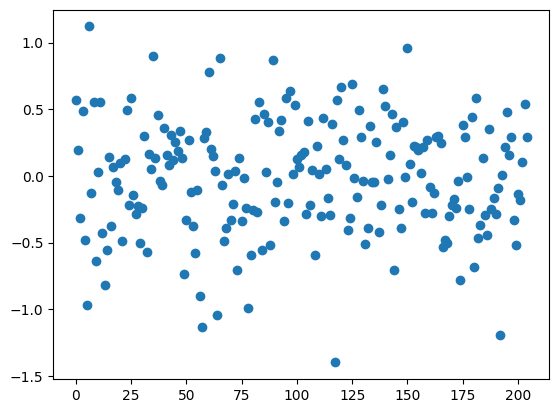

In [48]:
randomrank=generate_random_ranking_dict(SecuritiesCode)

train_subset['Rank']=train_subset['SecuritiesCode'].map(randomrank)
buf = train_subset.groupby('Date').apply(calc_spread_return_per_day)
sharpe_ratio = buf.mean() / buf.std()
print(buf)
plt.scatter(range(len(buf)),buf)
plt.show()

In [26]:
def generate_n_portfolios(SecuritiesCode,n):
    portfolios=[]
    for i in range(n):
        portfolios.append(generate_random_ranking_dict(SecuritiesCode))
    return portfolios

In [27]:
portfolios=generate_n_portfolios(SecuritiesCode,10000)


In [29]:
bufs=[]
for port in tqdm(portfolios):
    train_subset['Rank']=train_subset['SecuritiesCode'].map(port)
    buf = train_subset.groupby('Date').apply(calc_spread_return_per_day)
    bufs.append(buf)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [49]:
arr=np.array(bufs)
arr

array([[-0.37004593,  0.90839639,  0.07302899, ..., -0.02516684,
        -0.5069531 ,  0.37024417],
       [ 0.63170062,  0.07056787,  0.09869975, ...,  0.24553992,
        -0.1668462 , -0.01513302],
       [-0.25846587,  0.16045457,  0.09423729, ..., -0.36796011,
        -0.19849909, -0.37842287],
       ...,
       [-0.81361399,  0.35329636,  0.55234239, ...,  0.06853493,
        -0.70218114, -0.54972896],
       [ 0.22491792, -0.17421498,  0.14903644, ..., -0.22585485,
        -0.44437929, -0.35374331],
       [ 0.63502691,  0.95974956, -0.07662538, ..., -0.42698314,
         0.0865075 ,  0.46345975]])

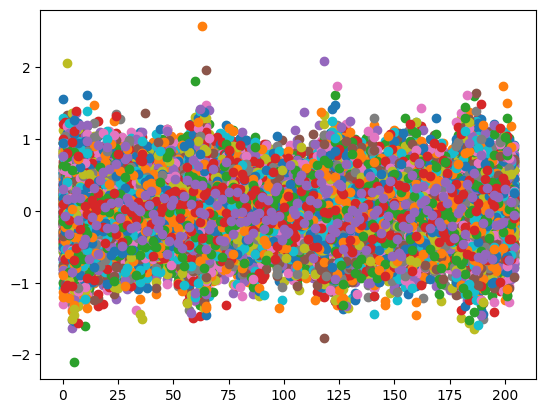

In [50]:
for i in range(len(arr[0])):
    plt.scatter(range(len(arr[0])),arr[i])

(array([ 6.,  8., 21., 39., 44., 36., 30., 14.,  6.,  1.]),
 array([-0.9760359 , -0.76386165, -0.5516874 , -0.33951315, -0.1273389 ,
         0.08483535,  0.2970096 ,  0.50918384,  0.72135809,  0.93353234,
         1.14570659]),
 <BarContainer object of 10 artists>)

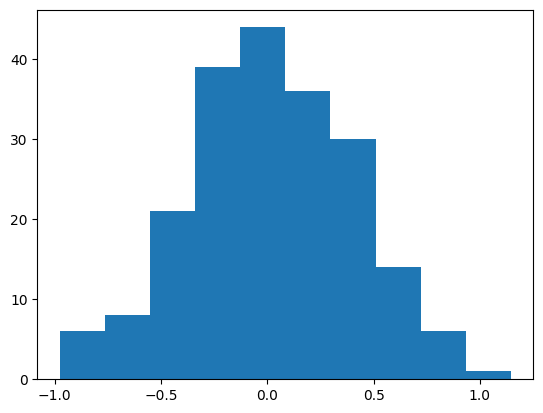

In [39]:
plt.hist2d(arr[0])

In [17]:
n=1000

for i in tqdm(range(n)):
    randomrank=generate_random_ranking_dict(SecuritiesCode)
    train_subset['Rank']=train_subset['SecuritiesCode'].map(randomrank)
    sharpe=calc_spread_return_sharpe(train_subset)
    sharpes.append(sharpe)

  0%|          | 0/1000 [00:00<?, ?it/s]

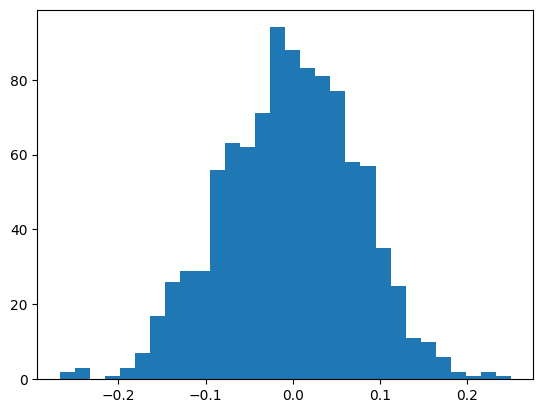

In [18]:
plt.hist(sharpes,bins=30)
plt.show()

References:

https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

https://www.kaggle.com/code/smeitoma/submission-demo

https://www.kaggle.com/code/smeitoma/train-demo

https://www.kaggle.com/code/kellibelcher/jpx-stock-market-analysis-prediction-with-lgbm